In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, gaussian_vel_reconstruction, normalize_matrix, moca, smooth


#### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}
    

#### Ship Data

In [3]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})

df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

# df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
# df_sadcp = df_sadcp[df_sadcp['Lon'] <= 155]
df_sadcp= df_sadcp.reset_index().drop(columns=['index'])

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_717,v_727,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807
0,2023-10-09 11:56:08.499988,151.320299,-33.889224,NaN,0.005571,0.025212,-0.104460,0.036320,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-09 12:13:38.666652,151.336628,-33.915619,NaN,-0.007718,0.051367,0.266196,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-09 12:26:08.500002,151.372994,-33.939047,NaN,-0.006178,-0.001007,0.025207,0.039912,0.058620,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-09 12:43:38.666665,151.426511,-33.973251,NaN,-0.040717,0.011668,0.069795,0.072353,0.056161,0.063086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-09 12:56:08.749984,151.464043,-33.998656,NaN,-0.054494,-0.046787,0.008042,0.045238,0.037273,0.037848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,2023-11-01 03:40:29.666685,152.133657,-33.499170,NaN,-0.193570,-0.174856,-0.137530,-0.129104,-0.171884,-0.182623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2170,2023-11-01 03:55:29.333340,152.162703,-33.499744,NaN,-0.265587,-0.234279,-0.260916,-0.220431,-0.168265,-0.207625,...,0.099449,0.131495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171,2023-11-01 04:10:29.666658,152.191377,-33.499695,NaN,-0.273816,-0.266387,-0.292629,-0.261923,-0.164615,-0.147517,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2172,2023-11-01 04:25:29.333353,152.220223,-33.499658,NaN,-0.283102,-0.277454,-0.314878,-0.320812,-0.254559,-0.195608,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### SWOT Data

In [4]:
lon0, lon1 = 153, 156
lat0, lat1 = -39, -37
tim0, tim1 = pd.Timestamp('2023-10-16 17:12:30.333340'), pd.Timestamp('2023-10-22 05:57:30.333340')


(-39.0, -37.0)

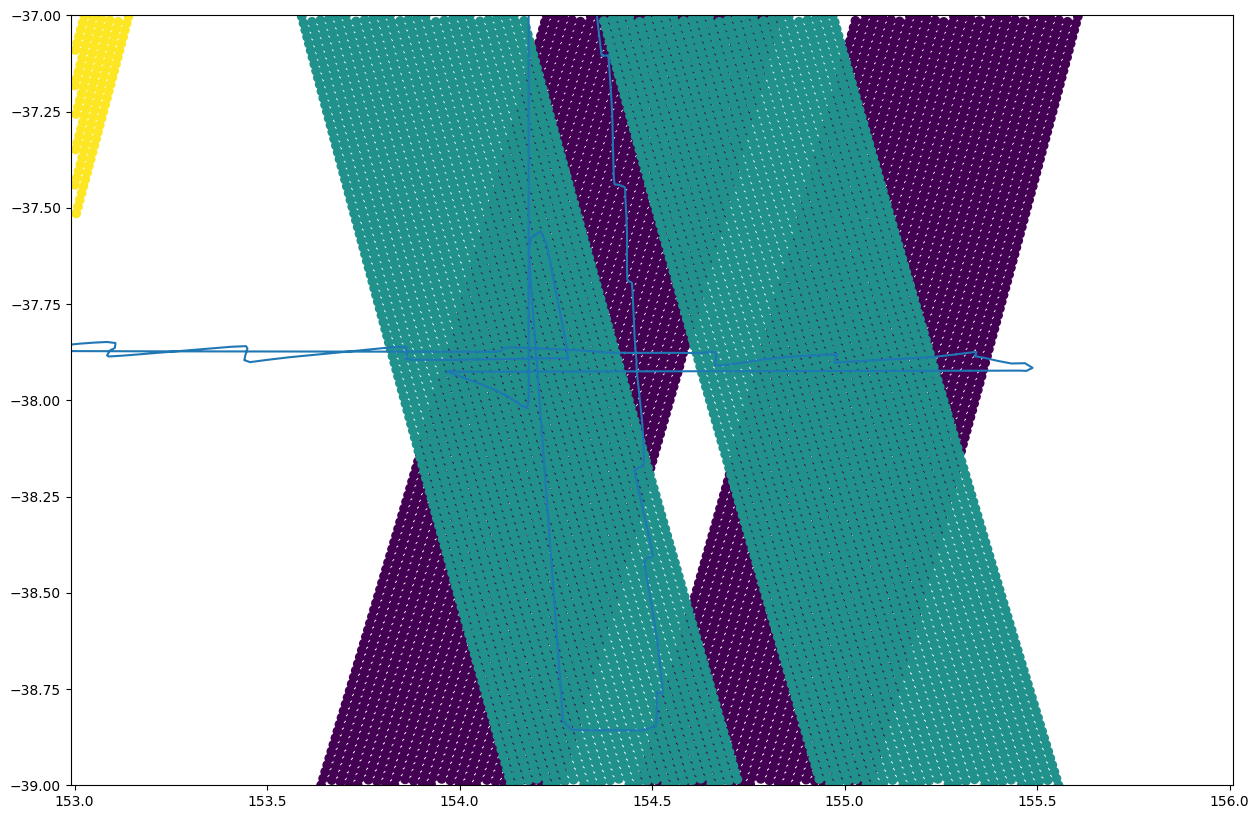

In [5]:
swot_path1 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_211_20231020T043758_20231020T052925_v2.0.1.nc'
swot_dataset1 = nc.Dataset(swot_path1, mode='r')

u_swot1, v_swot1 = swot_dataset1['ugos_filtered'][:].data, swot_dataset1['vgos_filtered'][:].data
lon_swot1, lat_swot1 = swot_dataset1['longitude'][:].data, swot_dataset1['latitude'][:].data
time_swot1 = swot_dataset1['time'][:].data

swot_path2 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_226_20231020T172941_20231020T182107_v2.0.1.nc'
swot_dataset2 = nc.Dataset(swot_path2, mode='r')

u_swot2, v_swot2 = swot_dataset2['ugos_filtered'][:].data, swot_dataset2['vgos_filtered'][:].data
lon_swot2, lat_swot2 = swot_dataset2['longitude'][:].data, swot_dataset2['latitude'][:].data
time_swot2 = swot_dataset2['time'][:].data

swot_path3 = '/srv/scratch/z5297792/IN2023/SWOT/SWOT_L3_LR_SSH_Expert_005_239_20231021T043829_20231021T052956_v2.0.1.nc'
swot_dataset3 = nc.Dataset(swot_path3, mode='r')

u_swot3, v_swot3 = swot_dataset3['ugos_filtered'][:].data, swot_dataset3['vgos_filtered'][:].data
lon_swot3, lat_swot3 = swot_dataset3['longitude'][:].data, swot_dataset3['latitude'][:].data
time_swot3 = swot_dataset3['time'][:].data

df_time1 = pd.DataFrame({'Time': pd.to_datetime(time_swot1, unit='s', origin='2000-01-01')})
df_time1 = df_time1.loc[df_time1.index.repeat(lon_swot1.shape[1])].reset_index(drop=True)
df_swot1 = pd.concat([
    pd.DataFrame({'ID': [1]*len(df_time1)}),
    df_time1,
    pd.DataFrame({'Lon': lon_swot1.ravel()}),
    pd.DataFrame({'Lat': lat_swot1.ravel()}),
    pd.DataFrame({'u': u_swot1.ravel()}),
    pd.DataFrame({'v': v_swot1.ravel()}),
], axis=1)

df_time2 = pd.DataFrame({'Time': pd.to_datetime(time_swot2, unit='s', origin='2000-01-01')})
df_time2 = df_time2.loc[df_time2.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot2 = pd.concat([
    pd.DataFrame({'ID': [2]*len(df_time2)}),
    df_time2,
    pd.DataFrame({'Lon': lon_swot2.ravel()}),
    pd.DataFrame({'Lat': lat_swot2.ravel()}),
    pd.DataFrame({'u': u_swot2.ravel()}),
    pd.DataFrame({'v': v_swot2.ravel()}),
], axis=1)

df_time3 = pd.DataFrame({'Time': pd.to_datetime(time_swot3, unit='s', origin='2000-01-01')})
df_time3 = df_time3.loc[df_time3.index.repeat(lon_swot2.shape[1])].reset_index(drop=True)
df_swot3 = pd.concat([
    pd.DataFrame({'ID': [3]*len(df_time3)}),
    df_time3,
    pd.DataFrame({'Lon': lon_swot3.ravel()}),
    pd.DataFrame({'Lat': lat_swot3.ravel()}),
    pd.DataFrame({'u': u_swot3.ravel()}),
    pd.DataFrame({'v': v_swot3.ravel()}),
], axis=1)

df_swot = pd.concat([df_swot1, df_swot2, df_swot3], axis=0)
df_swot = df_swot[np.hypot(df_swot.u, df_swot.v) < 100]  # FILTER!!
df_swot= df_swot.reset_index().drop(columns=['index'])

df = df_swot.copy()
df_CE = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
           (df.Lat >= lat0) & (df.Lat <= lat1) &
           (df.Time >= tim0) & (df.Time <= tim1)]

plt.figure(figsize=(15,10))
plt.scatter(df_CE.Lon, df_CE.Lat, c=df_CE.ID)
plt.plot(df_sadcp.Lon, df_sadcp.Lat)
plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)


### SWOT

In [6]:
lon0, lon1 = 153, 156
lat0, lat1 = -39.25, -36.5
tim0, tim1 = pd.Timestamp('2023-10-16 17:12:30.333340'), pd.Timestamp('2023-10-22 05:57:30.333340')


,ID,Time,Lon,Lat,u,v
604490,2,2023-10-20 18:06:01.547224760,153.504534,-36.501441,-0.3388,0.5423
604491,2,2023-10-20 18:06:01.547224760,153.482683,-36.505134,-0.2967,0.5935
604492,2,2023-10-20 18:06:01.547224760,153.460831,-36.508824,-0.2740,0.6214
604538,2,2023-10-20 18:06:01.860496044,153.618365,-36.500559,-0.6094,0.8299
604539,2,2023-10-20 18:06:01.860496044,153.596520,-36.504274,-0.5532,0.7976
...,...,...,...,...,...,...
613346,2,2023-10-20 18:06:54.181800365,155.557370,-39.240044,0.3773,-0.2677
613347,2,2023-10-20 18:06:54.181800365,155.534830,-39.244205,0.3859,-0.3149
613348,2,2023-10-20 18:06:54.181800365,155.512287,-39.248362,0.3967,-0.2699
613396,2,2023-10-20 18:06:54.495154381,155.630344,-39.245042,0.2212,-0.1638


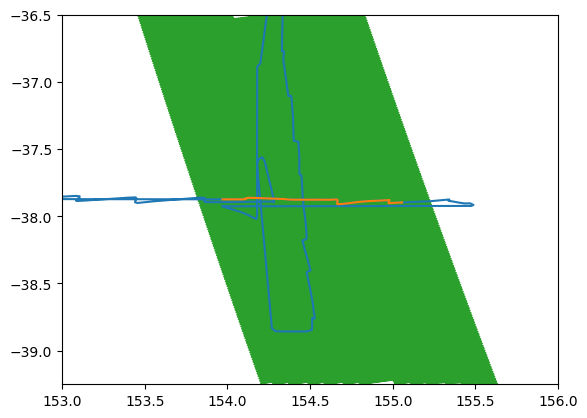

In [7]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

# t3 = pd.Timestamp('2023-10-20 14:00:00') # Good for MOCA
# days3 = .3

t_esp = pd.Timestamp('2023-10-20 14:00:00')
days_esp = .3

df_esp = df_sadcp[(df_sadcp.Time >= t_esp - pd.Timedelta(days=days_esp)) & (df_sadcp.Time <= t_esp + pd.Timedelta(days=days_esp))].copy()
plt.plot(df_esp.Lon, df_esp.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])

df = df_swot.copy()
df_app_esp = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
           (df.Lat >= lat0) & (df.Lat <= lat1) &
           (df.Time >= df_esp.Time.min()) & (df.Time <= df_esp.Time.max())]

plt.plot(df_app_esp.Lon, df_app_esp.Lat, zorder=-1)
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)

df_app_esp

154.23482487939538 -38.17816075447731 -1.542085442532099 [[-0.53938191  0.15220217]
 [ 0.15220217 -0.23166082]] 0.26447397753259577 1.5250540039601508


(-39.25, -36.5)

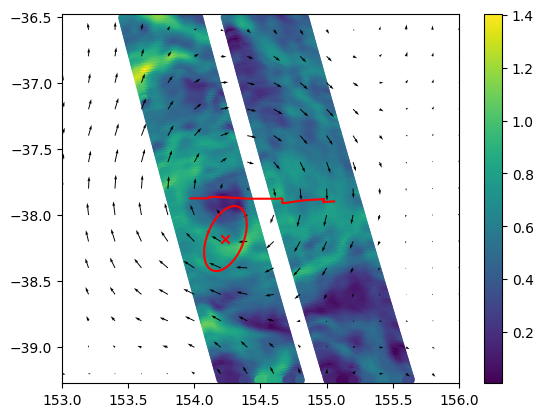

In [8]:
plt.scatter(df_app_esp.Lon, df_app_esp.Lat, c=np.hypot(df_app_esp.u, df_app_esp.v))
plt.colorbar()

closest = min(tim_ssh, key=lambda t: abs(t - t_esp))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
plt.quiver(lon_ssh, lat_ssh, ut, vt)

plt.plot(df_esp.Lon, df_esp.Lat, 'r')
xc, yc, w, Q, Rc, psi0 = espra(df_esp.Lon, df_esp.Lat, df_esp.u_37, df_esp.v_37)
print(xc, yc, w, Q, Rc, psi0)
plt.scatter(xc, yc, marker='x', color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=Rc)
plt.plot(x_ell, y_ell, 'r')

plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)


In [9]:
# x, y = np.linspace(lon0, lon1, 30), np.linspace(lat0, lat1, 20)
# X, Y = np.meshgrid(x, y)

# u, v, *_ = gaussian_vel_reconstruction(xc, yc, Q[0,0], Q[1,0], Q[1,1], Rc, psi0, X=X, Y=Y)
# plt.quiver(X, Y, u, v, scale=20, width=.0025)
# plt.axis('equal')


In [10]:
# from scipy.interpolate import griddata

# pts = np.stack((X.ravel(), Y.ravel()), axis=-1)
# u_vals = u.ravel()
# v_vals = v.ravel()

# u_esp, v_esp = [], []
# for k in range(len(df_app_esp)):
#     data = df_app_esp.iloc[k]
#     xp, yp = data.Lon, data.Lat
    
#     u_esp.append(griddata(pts, u_vals, (xp, yp), method='linear'))
#     v_esp.append(griddata(pts, v_vals, (xp, yp), method='linear'))
    
# df_app_esp['u_esp'] = u_esp
# df_app_esp['u_esp']= df_app_esp['u_esp'].astype(float)
# df_app_esp['v_esp'] = v_esp
# df_app_esp['v_esp']= df_app_esp['v_esp'].astype(float)

# df_app_esp.loc[:, 'u_err'] = np.abs(df_app_esp.u - df_app_esp.u_esp)
# df_app_esp.loc[:, 'v_err'] = np.abs(df_app_esp.v - df_app_esp.v_esp)

# speed_obs = np.hypot(df_app_esp.u, df_app_esp.v)
# speed_mod = np.hypot(df_app_esp.u_esp, df_app_esp.v_esp)

# df_app_esp.loc[:, 'err'] = np.abs(speed_obs - speed_mod) / speed_obs


In [11]:
# plt.scatter(df_app_esp.Lon, df_app_esp.Lat, c=df_app_esp.err, cmap='RdYlGn_r', vmin=0, vmax=.6)
# plt.colorbar(label=r'Error [ms$^{-1}$]')
# plt.quiver(X, Y, u, v, scale=20, width=.0025)
# plt.axis('equal')


In [12]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# sc1 = ax1.scatter(
#     df_app_esp.Lon,
#     df_app_esp.Lat,
#     c=np.hypot(df_app_esp.u, df_app_esp.v),
#     vmin=0,
#     s=7,
#     label='SWOT Data',
#     cmap='viridis'
# )
# fig.colorbar(sc1, ax=ax1, label=r'CS [ms$^{-1}$]')
# ax1.quiver(lon_ssh, lat_ssh, ut, vt, scale=20, width=.0025)
# ax1.plot(df_esp.Lon, df_esp.Lat, 'm', linewidth=2, label='Ship Track')
# ax1.scatter(xc, yc, marker='x', color='r', s=100, label='Eddy Center')
# ax1.plot(x_ell, y_ell, 'r', linewidth=2, label='Core Boundary')
# ax1.set_aspect('equal')
# ax1.set_xlim(lon0, lon1)
# ax1.set_ylim(lat0, lat1)
# ax1.set_title('Original Sampling')
# ax1.set_xlabel('Longitude (°E)')
# ax1.set_ylabel('Latitude (°N)')

# from matplotlib.lines import Line2D
# handles, labels = ax1.get_legend_handles_labels()
# arrow_handle = Line2D([0], [0], color='k', lw=0, marker=r'$\rightarrow$', markersize=10, label='IMOS Data')
# handles.append(arrow_handle)
# ax1.legend(handles=handles, loc='upper right')

# sc2 = ax2.scatter(
#     df_app_esp.Lon,
#     df_app_esp.Lat,
#     c=df_app_esp.err,
#     cmap='RdYlGn_r',
#     vmin=0,
#     vmax=.4,
#     s=7
# )
# fig.colorbar(sc2, ax=ax2, label=r'Relative Error in CS')
# ax2.quiver(X, Y, u, v, scale=20, width=.0025, color='b')
# ax2.scatter(xc, yc, marker='x', color='b', s=100)
# ax2.plot(x_ell, y_ell, 'b', linewidth=2)
# ax2.set_aspect('equal')
# ax2.set_xlim(lon0, lon1)
# ax2.set_ylim(lat0, lat1)
# ax2.set_title('MOCA Reconstruction')
# ax2.set_xlabel('Longitude (°E)')
# ax2.set_ylabel('Latitude (°N)')

# handles, labels = ax2.get_legend_handles_labels()
# arrow_handle = Line2D([0], [0], color='b', lw=0, marker=r'$\rightarrow$', markersize=10, label='MOCA \nReconstructed \nData')
# handles.append(arrow_handle)
# ax2.legend(handles=handles, loc='upper right')

# plt.tight_layout()
# plt.show()


### MOCA

In [13]:
def project_sadcp_data(x, y, u, v):

    num_points = len(x)

    df = pd.DataFrame({'x': x, 'y': y, 'u': u, 'v': v})
    df = df.sort_values(by='x').reset_index(drop=True)
    x, y, u, v = np.array(df['x']), np.array(df['y']), np.array(df['u']), np.array(df['v'])

    # Fit a best-fit line (y = m*x + c) using linear regression.
    A = np.vstack([x, np.ones(len(x))]).T
    m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
    # Create a unit direction vector along the best-fit line.
    direction = np.array([1, m])
    direction = direction / np.linalg.norm(direction)
    # Project each (x, y) point onto the line using the first point as reference.
    p0 = np.array([x[0], y[0]])
    points = np.column_stack((x, y))
    projections = np.dot(points - p0, direction)
    # Sort projections and corresponding velocities.
    sort_idx = np.argsort(projections)
    proj_sorted = projections[sort_idx]
    u_sorted = u[sort_idx]
    v_sorted = v[sort_idx]
    # Interpolate the velocity components on evenly spaced positions.
    new_distances = np.linspace(proj_sorted.min(), proj_sorted.max(), num_points)
    new_u = np.interp(new_distances, proj_sorted, u_sorted)
    new_v = np.interp(new_distances, proj_sorted, v_sorted)
    # Calculate new (x, y) points along the line.
    new_points = p0 + np.outer(new_distances, direction)
    # Create and return the output dataframe.
    x, y = new_points[:, 0], new_points[:, 1]

    cos_theta = 1 / np.sqrt(1+m**2)
    sin_theta = m / np.sqrt(1+m**2)
    V_N = -new_u * sin_theta + new_v * cos_theta
    V_T = new_v * sin_theta + new_u * cos_theta
        
    df_projected = pd.DataFrame({
        'x': x,
        'y': y,
        'u': new_u,
        'v': new_v,
        'V_N': V_N,
        'V_T': V_T,
        # 'l': new_distances
    })

    df_projected = df_projected.sort_values(by='x').reset_index(drop=True)

    df_projected['l'] = np.hypot(df_projected['x']-df_projected['x'].iloc[0], df_projected['y']-df_projected['y'].iloc[0])

    return df_projected, m

def translate_MOCA(x_l_start, y_l_start, m, l0, r0):

    x0 = (l0-r0*m)/np.sqrt(1+m**2) + x_l_start
    y0 = (l0*m+r0)/np.sqrt(1+m**2) + y_l_start
    
    return x0, y0


154.3126514483475 -37.96257304148605 -4.429860001112676 [[-1.107465  0.      ]
 [ 0.       -1.107465]] 0.6376112176294979 0.5562533044013689


(-39.25, -36.5)

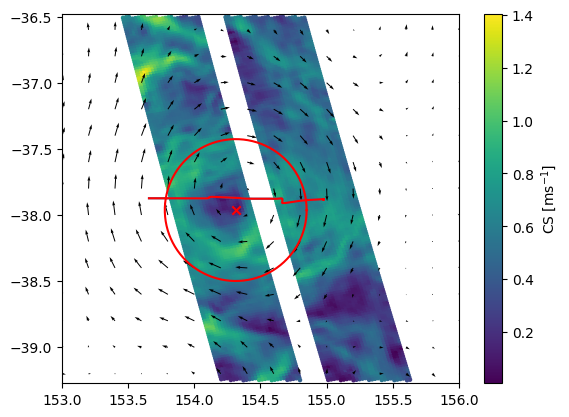

In [14]:
t_moca = pd.Timestamp('2023-10-20 12:00:00')
days3 = .3

df_moca = df_sadcp[(df_sadcp.Time >= t_moca - pd.Timedelta(days=days3)) & (df_sadcp.Time <= t_moca + pd.Timedelta(days=days3))]
plt.plot(df_moca.Lon, df_moca.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])

df = df_swot.copy()
df_app_moca = df[(df.Lon >= lon0) & (df.Lon <= lon1) &
           (df.Lat >= lat0) & (df.Lat <= lat1) &
           (df.Time >= df_moca.Time.min()) & (df.Time <= df_moca.Time.max())]

plt.scatter(df_app_moca.Lon, df_app_moca.Lat, c=np.hypot(df_app_moca.u, df_app_moca.v), s=5)
plt.colorbar(label=r'CS [ms$^{-1}$]')
closest = min(tim_ssh, key=lambda t: abs(t - t_moca))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
plt.quiver(lon_ssh, lat_ssh, ut, vt, scale=20, width=.0025)

plt.plot(df_moca.Lon, df_moca.Lat, 'r')

df_projected, m = project_sadcp_data(df_moca.Lon, df_moca.Lat, df_moca.u_37, df_moca.v_37)

l0, r0, w, Q, Rc, psi0 = moca(df_projected.l, df_projected.V_T, df_projected.V_N)
xc, yc = translate_MOCA(df_moca.iloc[0].Lon, df_moca.iloc[0].Lat, m, l0, r0)
moca_data = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0}
print(xc, yc, w, Q, Rc, psi0)

plt.scatter(xc, yc, marker='x', color='r')
x_ell, y_ell = plot_ellipse(Q, (xc, yc), scale=Rc)
plt.plot(x_ell, y_ell, 'r')

plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)


(np.float64(152.85),
 np.float64(156.15),
 np.float64(-39.3875),
 np.float64(-36.3625))

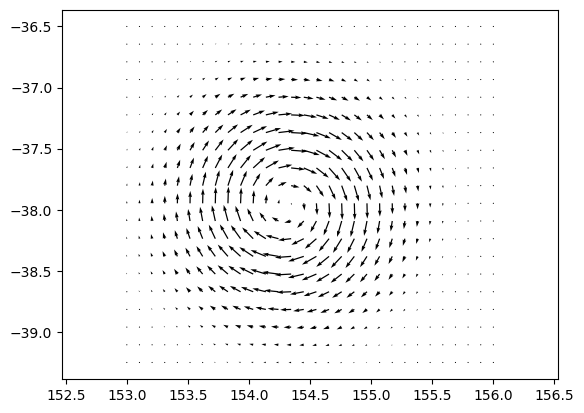

In [15]:
x, y = np.linspace(lon0, lon1, 30), np.linspace(lat0, lat1, 20)
X, Y = np.meshgrid(x, y)

u, v, *_ = gaussian_vel_reconstruction(xc, yc, Q[0,0], Q[1,0], Q[1,1], Rc, psi0, X=X, Y=Y)
plt.quiver(X, Y, u, v, scale=20, width=.0025)
plt.axis('equal')


Interpolate what my reconstructed u and v are at the SWOT points and compare

In [16]:
from scipy.interpolate import griddata

pts = np.stack((X.ravel(), Y.ravel()), axis=-1)
u_vals = u.ravel()
v_vals = v.ravel()

u_moc, v_moc = [], []
for k in range(len(df_app_moca)):
    data = df_app_moca.iloc[k]
    xp, yp = data.Lon, data.Lat
    
    u_moc.append(griddata(pts, u_vals, (xp, yp), method='linear'))
    v_moc.append(griddata(pts, v_vals, (xp, yp), method='linear'))
    
df_app_moca['u_moca'] = u_moc
df_app_moca['u_moca']= df_app_moca['u_moca'].astype(float)
df_app_moca['v_moca'] = v_moc
df_app_moca['v_moca']= df_app_moca['v_moca'].astype(float)

df_app_moca.loc[:, 'u_err'] = np.abs(df_app_moca.u - df_app_moca.u_moca)
df_app_moca.loc[:, 'v_err'] = np.abs(df_app_moca.v - df_app_moca.v_moca)

speed_obs = np.hypot(df_app_moca.u, df_app_moca.v)
speed_mod = np.hypot(df_app_moca.u_moca, df_app_moca.v_moca)

df_app_moca.loc[:, 'err'] = np.abs(speed_obs - speed_mod) / speed_obs

# df_app_moca.loc[:, 'err'] = np.abs(speed_obs - speed_mod)


/scratch/pbs.6724082.kman.restech.unsw.edu.au/ipykernel_2713360/3663481580.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_moca['u_moca'] = u_moc
/scratch/pbs.6724082.kman.restech.unsw.edu.au/ipykernel_2713360/3663481580.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_moca['u_moca']= df_app_moca['u_moca'].astype(float)
/scratch/pbs.6724082.kman.restech.unsw.edu.au/ipykernel_2713360/3663481580.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

(np.float64(152.85),
 np.float64(156.15),
 np.float64(-39.3875),
 np.float64(-36.3625))

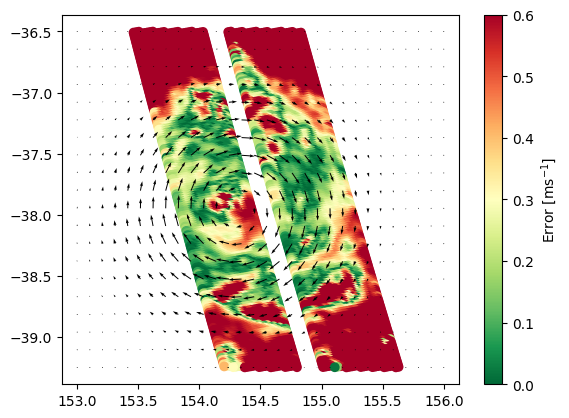

In [17]:
plt.scatter(df_app_moca.Lon, df_app_moca.Lat, c=df_app_moca.err, cmap='RdYlGn_r', vmin=0, vmax=.6)
plt.colorbar(label=r'Error [ms$^{-1}$]')
plt.quiver(X, Y, u, v, scale=20, width=.0025)
plt.axis('equal')


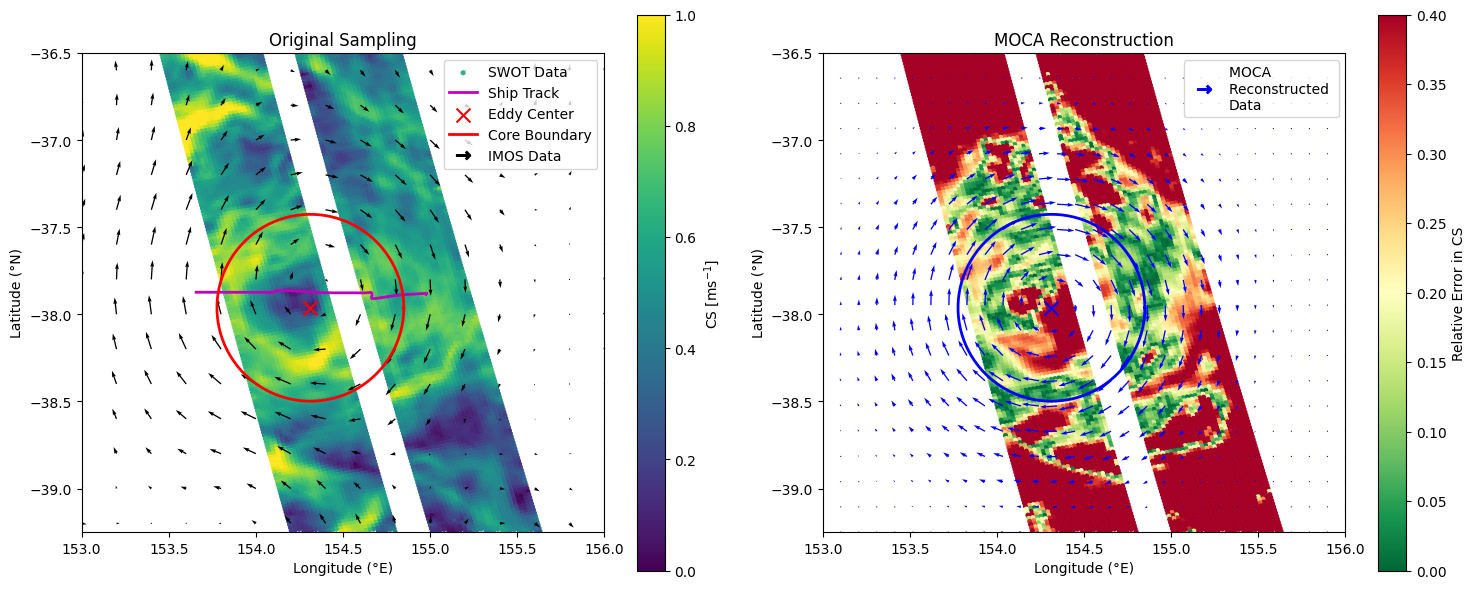

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sc1 = ax1.scatter(
    df_app_moca.Lon,
    df_app_moca.Lat,
    c=np.hypot(df_app_moca.u, df_app_moca.v),
    vmin=0,
    vmax=1,
    s=7,
    label='SWOT Data',
    cmap='viridis'
)
fig.colorbar(sc1, ax=ax1, label=r'CS [ms$^{-1}$]')
ax1.quiver(lon_ssh, lat_ssh, ut, vt, scale=20, width=.0025)
ax1.plot(df_moca.Lon, df_moca.Lat, 'm', linewidth=2, label='Ship Track')
ax1.scatter(xc, yc, marker='x', color='r', s=100, label='Eddy Center')
ax1.plot(x_ell, y_ell, 'r', linewidth=2, label='Core Boundary')
ax1.set_aspect('equal')
ax1.set_xlim(lon0, lon1)
ax1.set_ylim(lat0, lat1)
ax1.set_title('Original Sampling')
ax1.set_xlabel('Longitude (°E)')
ax1.set_ylabel('Latitude (°N)')

from matplotlib.lines import Line2D
handles, labels = ax1.get_legend_handles_labels()
arrow_handle = Line2D([0], [0], color='k', lw=0, marker=r'$\rightarrow$', markersize=10, label='IMOS Data')
handles.append(arrow_handle)
ax1.legend(handles=handles, loc='upper right')

sc2 = ax2.scatter(
    df_app_moca.Lon,
    df_app_moca.Lat,
    c=df_app_moca.err,
    cmap='RdYlGn_r',
    vmin=0,
    vmax=.4,
    s=7
)
fig.colorbar(sc2, ax=ax2, label=r'Relative Error in CS')
ax2.quiver(X, Y, u, v, scale=20, width=.0025, color='b')
ax2.scatter(xc, yc, marker='x', color='b', s=100)
ax2.plot(x_ell, y_ell, 'b', linewidth=2)
ax2.set_aspect('equal')
ax2.set_xlim(lon0, lon1)
ax2.set_ylim(lat0, lat1)
ax2.set_title('MOCA Reconstruction')
ax2.set_xlabel('Longitude (°E)')
ax2.set_ylabel('Latitude (°N)')

handles, labels = ax2.get_legend_handles_labels()
arrow_handle = Line2D([0], [0], color='b', lw=0, marker=r'$\rightarrow$', markersize=10, label='MOCA \nReconstructed \nData')
handles.append(arrow_handle)
ax2.legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.show()


#### Use ESPRA on the SWOT data to get benchmark results

In [19]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
xc, yc, w, Q, Rc, psi0 = moca_data['xc'], moca_data['yc'], moca_data['w'], moca_data['Q'], moca_data['Rc'], moca_data['psi0']
plt.scatter(df_app_moca.Lon, df_app_moca.Lat, c=np.hypot(df_app_moca.u, df_app_moca.v), s=5)
closest = min(tim_ssh, key=lambda t: abs(t - t_moca))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
plt.quiver(lon_ssh, lat_ssh, ut, vt, scale=20, width=.0025)

eddy_mask = np.hypot(df_app_moca.Lon - xc, df_app_moca.Lat - yc) < Rc
df = df_app_moca[eddy_mask].copy()
xc, yc, w, Q, Rc, psi0 = espra(df.Lon, df.Lat, df.u, df.v, Rc_max=1, flag_km=False)
espra_swot_data = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0}

df_data = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0'])
df_data.loc[0] = moca_data
df_data.loc[1] = espra_swot_data
df_data.index = ['MOCA', 'SWOT_ESP']

plt.plot(df_moca.Lon, df_moca.Lat, 'r')

clrs = ['r', 'orange']
for k in range(len(df_data)):
    data = df_data.iloc[k]
    plt.scatter(data.xc, data.yc, marker='x', label=data.name, color=clrs[k])
    x_ell, y_ell = plot_ellipse(data.Q, (data.xc, data.yc), scale=data.Rc)
    plt.plot(x_ell, y_ell, color=clrs[k])
plt.legend()
plt.axis('equal')
plt.xlim(lon0, lon1); plt.ylim(lat0, lat1)



In [ ]:
df_data

Reconstruct SWOT ESPRA output

In [ ]:
x, y = np.linspace(lon0, lon1, 30), np.linspace(lat0, lat1, 20)
X, Y = np.meshgrid(x, y)

data = df_data.iloc[1]
u, v, *_ = gaussian_vel_reconstruction(data.xc, data.yc, data.Q[0,0], data.Q[1,0], data.Q[1,1],
                                       data.Rc, data.psi0, X=X, Y=Y)
plt.quiver(X, Y, u, v, scale=20, width=.0025)
plt.axis('equal')


In [ ]:
from scipy.interpolate import griddata

pts = np.stack((X.ravel(), Y.ravel()), axis=-1)
u_vals = u.ravel()
v_vals = v.ravel()

u_esp, v_esp = [], []
for k in range(len(df_app_moca)):
    data = df_app_moca.iloc[k]
    xp, yp = data.Lon, data.Lat
    
    u_esp.append(griddata(pts, u_vals, (xp, yp), method='linear'))
    v_esp.append(griddata(pts, v_vals, (xp, yp), method='linear'))
    
df_app_moca['u_esp'] = u_esp
df_app_moca['u_esp']= df_app_moca['u_esp'].astype(float)
df_app_moca['v_esp'] = v_esp
df_app_moca['v_esp']= df_app_moca['v_esp'].astype(float)

df_app_moca.loc[:, 'u_err'] = np.abs(df_app_moca.u - df_app_moca.u_esp)
df_app_moca.loc[:, 'v_err'] = np.abs(df_app_moca.v - df_app_moca.v_esp)

speed_obs = np.hypot(df_app_moca.u, df_app_moca.v)
speed_mod = np.hypot(df_app_moca.u_esp, df_app_moca.v_esp)

df_app_moca.loc[:, 'err'] = np.abs(speed_obs - speed_mod) / speed_obs

# df_app_moca.loc[:, 'err'] = np.abs(speed_obs - speed_mod)


In [ ]:
plt.scatter(df_app_moca.Lon, df_app_moca.Lat, c=df_app_moca.err, cmap='RdYlGn_r', vmin=0, vmax=.6, s=5)
plt.colorbar(label='Relative Error in CS')
plt.quiver(X, Y, u, v, scale=20, width=.0025)
plt.axis('equal')
